Read data:

In [211]:
import matplotlib.pyplot as plt
import numpy as np
import os
filepath = os.path.join("CTD_measurements", "CTD7708-20241018-MIR-5.cnv")

# Open the file in read mode ('r')
with open(filepath, 'r') as file:
    # Read the contents of the file
    start_reading = False
    Temp_col = []
    Pressure_col = []
    Salinity_col = []
    Oxygen_col = []
    Irradiance_col = []

    # Loop through each line in the file
    for line in file:
        # Check for the *END* marker
        if '*END*' in line:
            start_reading = True
            continue  # Skip processing this line, as it is just the marker
        
        # If *END* has been found, start reading third columns
        if start_reading:
            # Split the line into columns (assuming it's space-separated)
            columns = line.split()
            
            Temp_col.append(columns[2])  # Third column (index 2)
            Pressure_col.append(columns[1])
            Salinity_col.append(columns[8])
            Oxygen_col.append(columns[7])
            Irradiance_col.append(columns[4])



# Transforming the input into float values
Temp_col = [float(i) for i in Temp_col]
Pressure_col = [float(i) for i in Pressure_col]
Salinity_col = [float(i) for i in Salinity_col]
Oxygen_col = [float(i) for i in Oxygen_col]
Irradiance_col = [float(i) for i in Irradiance_col]

# Filtering the values when the CTD is in the air by removing the subset of values where salinity is low (<30)
get_underwater_it = 0
while Salinity_col[get_underwater_it] < 36:
    get_underwater_it = get_underwater_it+1

temperature = Temp_col[get_underwater_it:]
pressure = Pressure_col[get_underwater_it:]
salinity = Salinity_col[get_underwater_it:]
oxygen = Oxygen_col[get_underwater_it:]
irradiance = Irradiance_col[get_underwater_it:]


# Filtering the values when the CTD is back in the air when pulled, same principle
get_overwater_it = len(salinity) - 1
while salinity[get_overwater_it] < 36:
    get_overwater_it = get_overwater_it-1

# get_overwater_it = get_overwater_it -10
temperature = temperature[:get_overwater_it]
pressure = pressure[:get_overwater_it]
salinity = salinity[:get_overwater_it]
oxygen = oxygen[:get_overwater_it]
irradiance = irradiance[:get_overwater_it]
erronous_vals =0
for s in range(len(salinity)):
    # Any salinity value below 30 is not valid for the Mediterranean Sea
    if salinity[s] < 30:
        # List of neighboring indices to check for valid values
        neighbors = [s-1, s+1, s-2, s+2]
        
        # Find the first valid neighboring value
        for n in neighbors:
            if 0 <= n < len(salinity) and salinity[n] > 30:  # Ensure index is valid and salinity is acceptable
                salinity[s] = salinity[n]
                break

for s in range(len(salinity)):
    
        # moving average for salinity with window 5
        salinity[s] = (salinity[s-5] + salinity[s-5] +salinity[s+5]+salinity[s+5])/4
        filtered+=1
print(filtered)

print(temperature)
print(len(pressure))
print(len(salinity))
print(oxygen)
print(irradiance)


[18.1181, 18.8556, 19.4629, 19.799, 19.9738, 20.0728, 20.1407, 20.1928, 20.2286, 20.2509, 20.2645, 20.2708, 20.2636, 20.2404, 20.2237, 20.2235, 20.232, 20.2395, 20.2424, 20.243, 20.2453, 20.2496, 20.2548, 20.2578, 20.2568, 20.2529, 20.2515, 20.2503, 20.2499, 20.2502, 20.2521, 20.2551, 20.258, 20.2598, 20.2606, 20.2607, 20.2604, 20.2595, 20.2592, 20.259, 20.2562, 20.2493, 20.2426, 20.2386, 20.2349, 20.2312, 20.229, 20.2304, 20.2353, 20.2411, 20.2455, 20.2492, 20.2526, 20.2533, 20.2467, 20.2402, 20.2174, 20.1958, 20.193, 20.2046, 20.2207, 20.2353, 20.2449, 20.2508, 20.2556, 20.2449, 20.2097, 20.1687, 20.1444, 20.134, 20.1485, 20.1737, 20.1959, 20.2133, 20.2271, 20.237, 20.2411, 20.2392, 20.2392, 20.2306, 20.2007, 20.1562, 20.1222, 20.106, 20.1063, 20.1295, 20.1643, 20.196, 20.2204, 20.2366, 20.2464, 20.2535, 20.2563, 20.2438, 20.2489, 20.2695, 20.2856, 20.2958, 20.3025, 20.307, 20.3098, 20.3114, 20.3122, 20.3126, 20.3128, 20.3116, 20.3104, 20.3095, 20.3092, 20.3093, 20.3099, 20.3112, 20.

Calculate the depth:

In [212]:
import gsw


# Calculate the depth (in meters) from pressure

depth = []
latitude = 43

for i in range(len(pressure)):
    depth.append(gsw.z_from_p(pressure[i],latitude) *-1)

print(len(depth))


3019


Clean data:

In [213]:
# Function to apply a moving average LPF
def moving_average(data, window_size):
    """
    Apply a moving average low-pass filter to the data.
    
    Args:
        data (array-like): The input data array.
        window_size (int): The size of the moving average window.
        
    Returns:
        np.ndarray: The filtered data.
    """
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

window_size = 51
pad_size = window_size//2 
print(pad_size)
print(len(salinity))
padded_data = np.pad(salinity, pad_width=pad_size, mode='edge')

salinity_filtered = moving_average(data=padded_data, window_size=window_size)
# salinity_filtered = salinity_filtered[pad_size:-pad_size]
salinity_filtered = salinity_filtered.tolist()
print(len(salinity_filtered))




25
3019
3019


Plot:

1179
1179


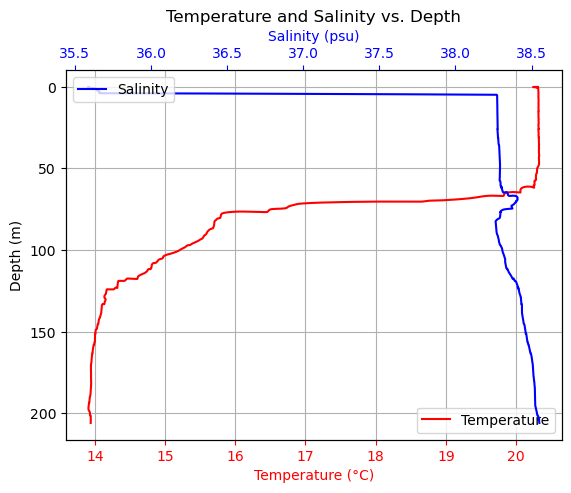

In [214]:
max_depth = max(depth)
max_index = depth.index(max_depth)
# upcast, removing the downcast subset
temperature = temperature[max_index:]
pressure = pressure[max_index:]
salinity = salinity_filtered[max_index:]
depth = depth[max_index:]
oxygen = oxygen[max_index:]
irradiance = irradiance[max_index:]

#downcast
# temperature = temperature[:max_index]
# pressure = pressure[:max_index]
# salinity = salinity_filtered[:max_index]
# depth = depth[:max_index]
# oxygen = oxygen[:max_index]
# irradiance = irradiance[:max_index]

print(len(depth))
print(len(salinity))


# Create the main plot
# fig, temp_axis = plt.subplots()

# plt.plot(temperature, depth, label="temperature", color='b')


# plt.figure()
# plt.plot(oxygen, depth, label="oxygen", color="black")
# plt.xlabel('Oxygen(umol/l)')
# plt.ylabel('Depth (m)')
# plt.title('Oxygen vs. Depth')
# plt.gca().invert_yaxis()  # This line inverts the y-axis
# ## plt.legend()

# plt.figure()
# plt.plot(irradiance, depth, label="irradiance", color="g")
# plt.xlabel('irradiance')
# plt.ylabel('Depth (m)')
# plt.title('Irradiance vs. Depth')
# plt.gca().invert_yaxis()  # This line inverts the y-axis
####################################################

# Create the plot
fig, ax1 = plt.subplots()

# Plot temperature vs depth (bottom x-axis)
ax1.plot(temperature, depth, color='red', label='Temperature')
ax1.set_xlabel('Temperature (°C)', color='red')
ax1.tick_params(axis='x', colors='red')

# Invert the y-axis to display depth increasing downwards
ax1.set_ylabel('Depth (m)')
ax1.invert_yaxis()
ax1.grid()

# Create a second x-axis (top) for salinity
ax2 = ax1.twiny()  # Add a second x-axis that shares the same y-axis
ax2.plot(salinity, depth, color='blue', label='Salinity')
ax2.set_xlabel('Salinity (psu)', color='blue')
ax2.tick_params(axis='x', colors='blue')

# Set the title
plt.title('Temperature and Salinity vs. Depth')

# Add legends for clarity
ax1.legend(loc='lower right')
ax2.legend(loc='upper left')

# Show the plot
plt.show()

####################################################
# plt.figure()
# plt.plot(salinity, depth, label="salinity", color="b")
# plt.xlabel('Salinity')
# plt.ylabel('Depth (m)')
# plt.title('Salinity vs. Depth with LPF')
# plt.grid()
# plt.gca().invert_yaxis()  # This line inverts the y-axis


# # Set axis labels and title
# plt.figure()
# plt.plot(temperature, depth, label="temperature", color="r")
# plt.xlabel('Temperature (°C)')
# plt.ylabel('Depth (m)')
# plt.title('Temperature vs. Depth')

# # Invert the y-axis to show depth increasing downwards
# plt.gca().invert_yaxis()  # This line inverts the y-axis

# # Show grid for better readability
# plt.grid()

# # Show the plot
# plt.show()
